In [1]:
import os 
import sys
import time

paths_to_add = [
    os.path.abspath(os.path.join('../..')),  
    os.path.abspath(os.path.join('..'))  
]

sys.path.extend(path for path in paths_to_add if path not in sys.path)

In [14]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import numpy as np
import scipy.stats
from jax import random
import matplotlib.pyplot as plt

from fbpinns import networks
from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.schedulers import LineSchedulerRectangularND, AllActiveSchedulerND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

from cooksDomain import CooksDomainND
from CooksMembrane.cooksProblem import CooksProblemForwardSoft

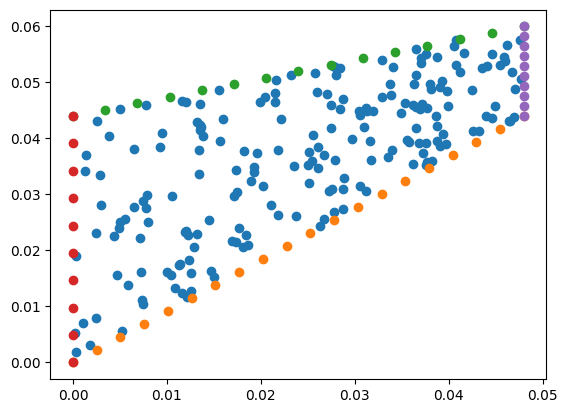

In [3]:
# step 1: Domain
corners = jnp.array([(0., 0.), (0, 0.044), (0.048, 0.060), (0.048, 0.044)]) 
domain = CooksDomainND
domain_init_kwargs = dict(
    corners=corners,
)
domain_init_kwargs

# Example 2D Plot
key = jax.random.PRNGKey(0)
all_params = {
    "static": {
        "domain": {
            "xd": 2,
            "corners": corners,
        }
    }
}

batch_shape = (10,20)  # for example
x_batch = domain.sample_interior(all_params, key, 'uniform', batch_shape)

batch_shapes = ((20,),(15,),(10,),(10,)) # bottom, top, left, right
x_boundaries = domain.sample_boundaries(all_params, key, 'grid', batch_shapes)

plt.scatter(x_batch[:, 0:1], x_batch[:, 1:2])
for x_batch_b in x_boundaries:
        plt.scatter(x_batch_b[:,0], x_batch_b[:,1], )

In [4]:
# step 2: prbolem
problem = CooksProblemForwardSoft
problem_init_kwargs = dict(lambda_true= 4, mu_true = 5, 
                    nbc_points_right = 200, nbc_points_top=200, 
                    nbc_points_bottom=200, dbc_points_left=200, sd=0.1)
problem_init_kwargs

{'lambda_true': 4,
 'mu_true': 5,
 'nbc_points_right': 200,
 'nbc_points_top': 200,
 'nbc_points_bottom': 200,
 'dbc_points_left': 200,
 'sd': 0.1}

{'subdomain_xs': [array([0.   , 0.048]), array([0.  , 0.06])], 'subdomain_ws': [array([0.072, 0.072]), array([0.09, 0.09])], 'unnorm': (0.0, 3.0)}


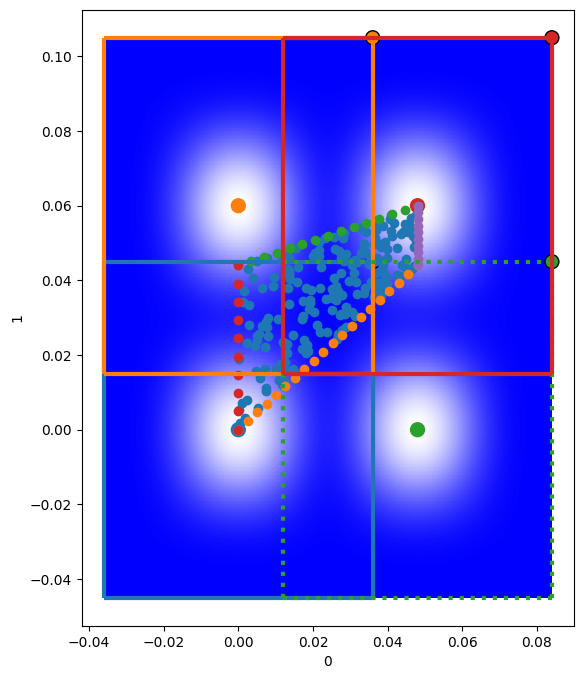

In [5]:
# step 3: decompostion
decomposition = RectangularDecompositionND
wo = 1.5
subdomain_xs = [np.linspace(0,0.048,2), np.linspace(0,0.060,2)]
#subdomain_xs = [[0.012, 0.034], [0.022, 0.052]]
subdomain_ws=get_subdomain_ws(subdomain_xs, wo)
decomposition_init_kwargs = dict(
    subdomain_xs=subdomain_xs,
    subdomain_ws=get_subdomain_ws(subdomain_xs, wo),
    unnorm=(0.,3.),
)
print(decomposition_init_kwargs)

# plot 2D
ps_ = decomposition.init_params(subdomain_xs, subdomain_ws, (0,3))
all_params = {"static":{"decomposition":ps_[0]}, "trainable":{"decomposition":ps_[1]}}
m = all_params["static"]["decomposition"]["m"]
active = np.ones(m)

# active[1] = 0
active[2] = 2
decomposition.plot(all_params, active=active, show_norm=True, show_window=True)

# for x in x_batch:
#     plt.scatter(x[0], x[1])
plt.scatter(x_batch[:, 0:1], x_batch[:, 1:2])
for x_batch_b in x_boundaries:
        plt.scatter(x_batch_b[:,0], x_batch_b[:,1], )
plt.show()

In [6]:
# step 4: network
network=FCN
network_init_kwargs = dict(
    layer_sizes = (2, 16, 5),
)

In [7]:
# step 5 scheduler # try with all active together
scheduler = AllActiveSchedulerND
scheduler_kwargs = dict()
# scheduler = LineSchedulerRectangularND
# scheduler_kwargs = dict(
#     point=[0.], iaxis=0,
# )

In [8]:
tag = "adaptive"
nc = (25,15)
epochs = 50000
h = len(network_init_kwargs["layer_sizes"]) - 2
p = sum(network_init_kwargs["layer_sizes"][1:-1])
run = f"FBPINN_{tag}_{problem.__name__}_{network.__name__}_{nc}-nCol_{epochs}-epochs_{h}-layers_{p}-hidden_{wo}_wo_{LineSchedulerRectangularND.__name__}_"
run

'FBPINN_adaptive_CooksProblemForwardSoft_FCN_(25, 15)-nCol_50000-epochs_1-layers_16-hidden_1.5_wo_LineSchedulerRectangularND_'

In [9]:

from fbpinns.constants import Constants

c = Constants(
    run=run,
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    ns=(nc,),# use 200 collocation points for training
    n_test=(50,50),# use 500 points for testing
    n_steps=epochs,# number of training steps
    clear_output=True,
    show_figures=False,
    test_freq=150000,
    skip_plot_at_first=True,
)
print(c)

run: FBPINN_adaptive_CooksProblemForwardSoft_FCN_(25, 15)-nCol_50000-epochs_1-layers_16-hidden_1.5_wo_LineSchedulerRectangularND_
domain: <class 'cooksDomain.CooksDomainND'>
domain_init_kwargs: {'corners': Array([[0.   , 0.   ],
       [0.   , 0.044],
       [0.048, 0.06 ],
       [0.048, 0.044]], dtype=float32)}
problem: <class 'CooksMembrane.cooksProblem.CooksProblemForwardSoft'>
problem_init_kwargs: {'lambda_true': 4, 'mu_true': 5, 'nbc_points_right': 200, 'nbc_points_top': 200, 'nbc_points_bottom': 200, 'dbc_points_left': 200, 'sd': 0.1}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.   , 0.048]), array([0.  , 0.06])], 'subdomain_ws': [array([0.072, 0.072]), array([0.09, 0.09])], 'unnorm': (0.0, 3.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': (2, 16, 5)}
n_steps: 50000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((25, 15),)
n

In [10]:
training_time = time.time()
FBPINNrun = FBPINNTrainer(c)
FBPINNrun.train()

training_time = time.time() - training_time
print(training_time)

[INFO] 2024-03-25 21:09:03 - <fbpinns.constants.Constants object at 0x0000026AA73BBF50>
run: FBPINN_adaptive_CooksProblemForwardSoft_FCN_(25, 15)-nCol_50000-epochs_1-layers_16-hidden_1.5_wo_LineSchedulerRectangularND_
domain: <class 'cooksDomain.CooksDomainND'>
domain_init_kwargs: {'corners': Array([[0.   , 0.   ],
       [0.   , 0.044],
       [0.048, 0.06 ],
       [0.048, 0.044]], dtype=float32)}
problem: <class 'CooksMembrane.cooksProblem.CooksProblemForwardSoft'>
problem_init_kwargs: {'lambda_true': 4, 'mu_true': 5, 'nbc_points_right': 200, 'nbc_points_top': 200, 'nbc_points_bottom': 200, 'dbc_points_left': 200, 'sd': 0.1}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.   , 0.048]), array([0.  , 0.06])], 'subdomain_ws': [array([0.072, 0.072]), array([0.09, 0.09])], 'unnorm': (0.0, 3.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': (2, 16, 5)}
n_steps: 50000
scheduler: 

In [11]:
from FBPINNsModel.plot import load_FBPINN, load_PINN, exact_solution
from fbpinns.analysis import load_model

# run = "test"
# load model
c, model = load_model(run, rootdir="results/")

# Test model
from fbpinns.analysis import FBPINN_solution, PINN_solution
i, all_params, all_opt_states, active, u_test_losses = model
x_batch_test = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=(100,100))
out = FBPINN_solution(c, all_params, active, x_batch_test)

ux_test, uy_test, sigaxx_test, sigmayy_test, sigmaxy_test  = out[:,0:1],out[:,1:2],out[:,2:3],out[:,3:4],out[:,4:5]

[INFO] 2024-03-25 21:11:11 - Loading model from:
results/models/FBPINN_adaptive_CooksProblemForwardSoft_FCN_(25, 15)-nCol_50000-epochs_1-layers_16-hidden_1.5_wo_LineSchedulerRectangularND_/model_00050000.jax
[INFO] 2024-03-25 21:11:12 - x_batch
[INFO] 2024-03-25 21:11:12 - (10000, 2), float32, ArrayImpl
[INFO] 2024-03-25 21:11:12 - x_take
[INFO] 2024-03-25 21:11:12 - (24994, 2), float32, ArrayImpl


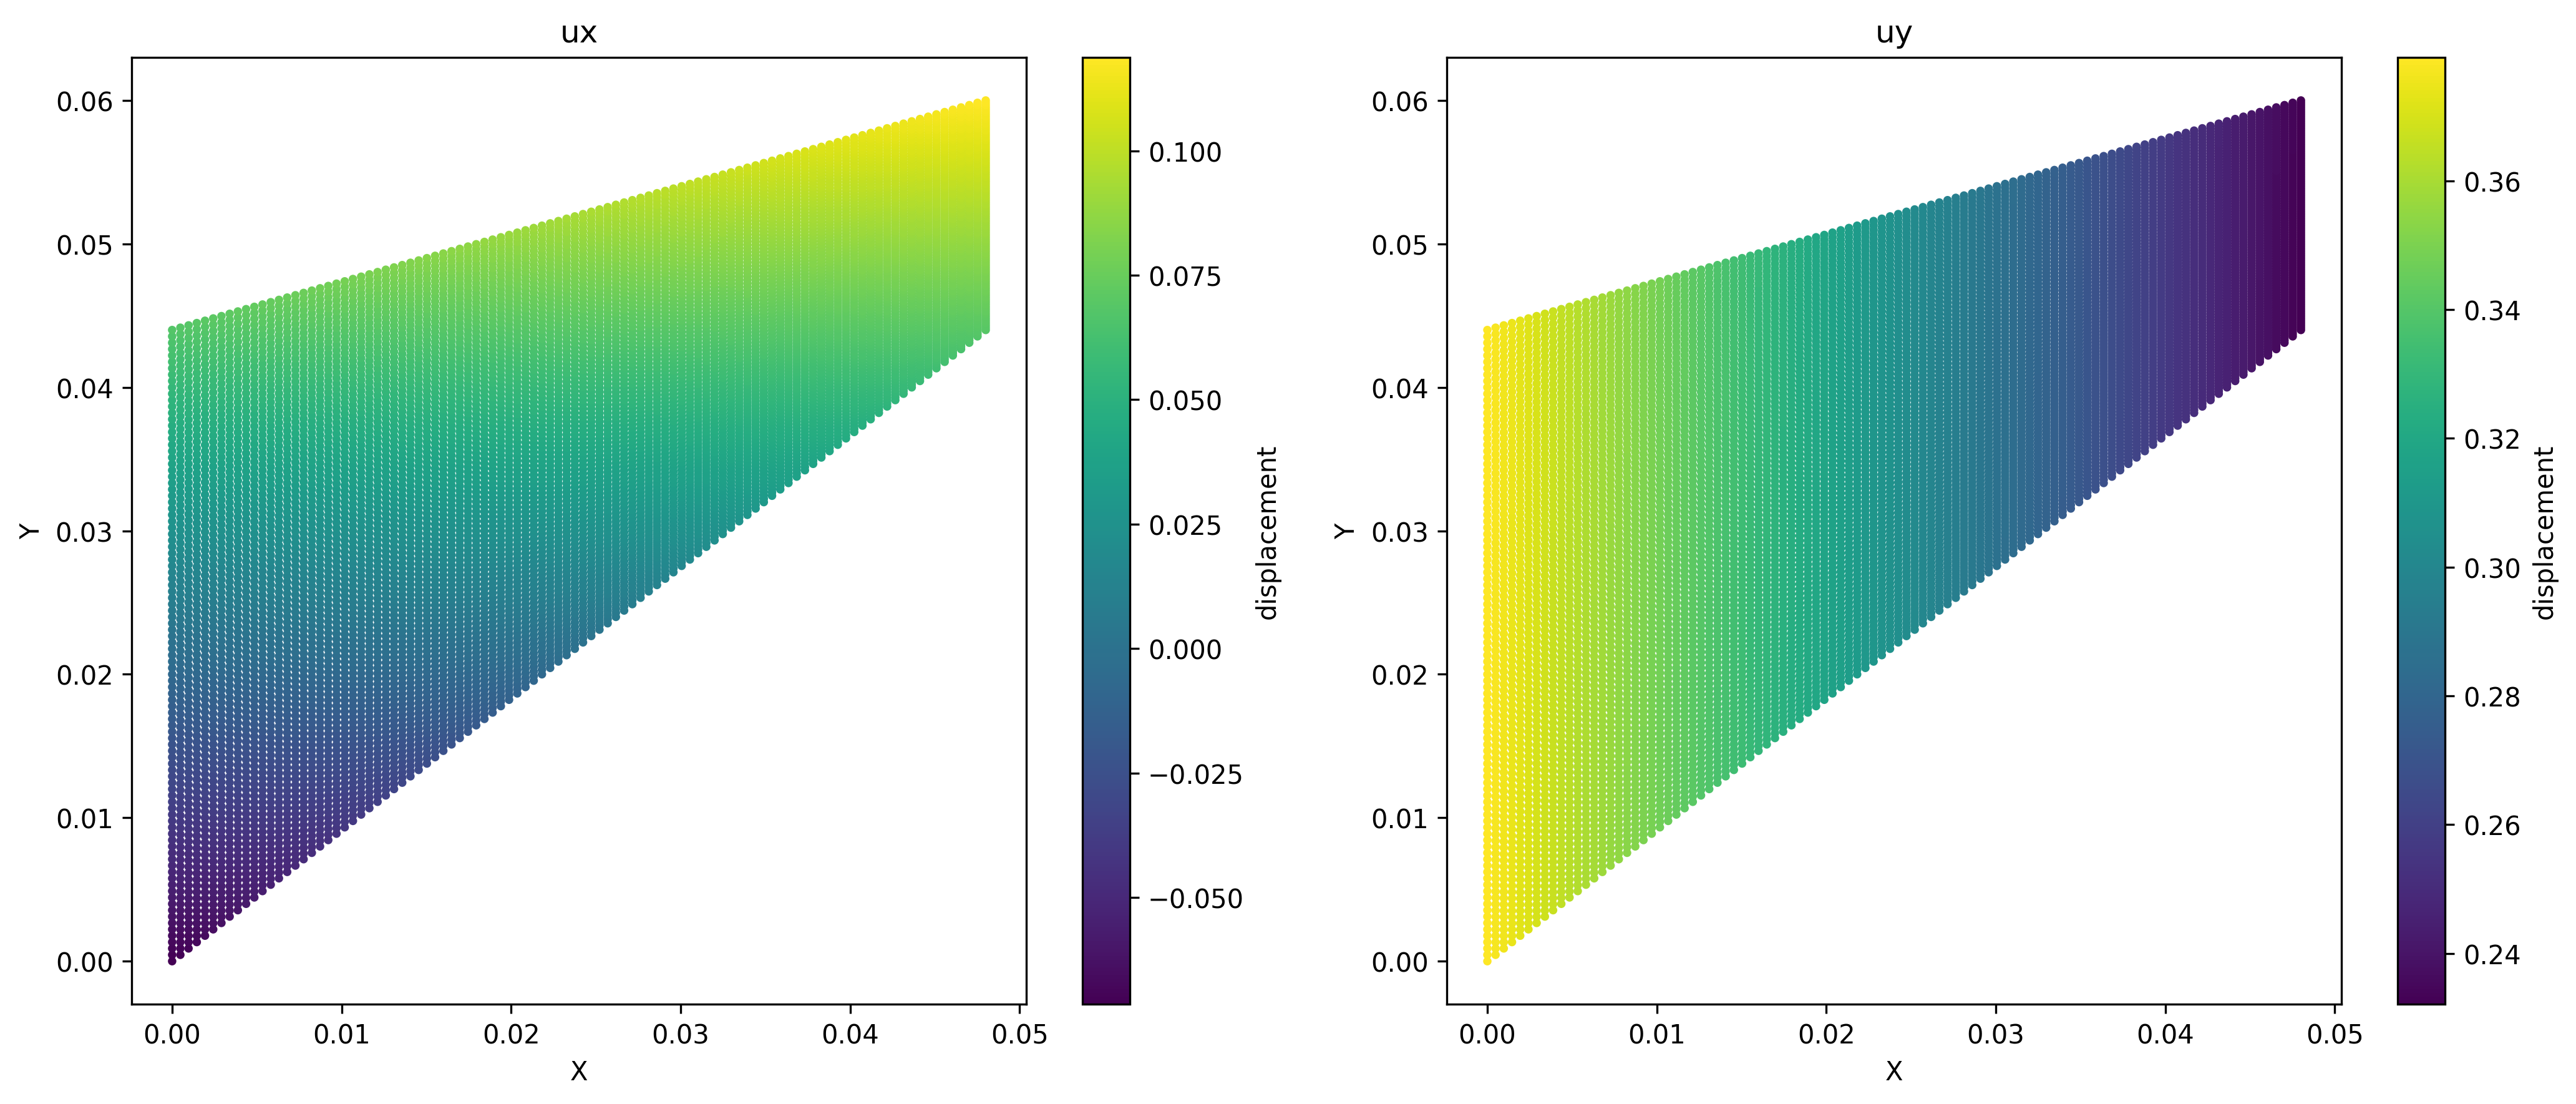

In [12]:
from CooksMembrane.util import plot_deformation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
plot_deformation(ux_test, x_batch_test,ax1,"ux")
plot_deformation(uy_test, x_batch_test,ax2,"uy")
plt.tight_layout()
plt.show()

In [13]:
E = 4 * jnp.einsum("ij, kl->ijkl", jnp.eye(2), jnp.eye(2)) + 5 *(
                jnp.einsum("ik, jl->ijkl", jnp.eye(2), jnp.eye(2)) + jnp.einsum("il, jk->ijkl", jnp.eye(2), jnp.eye(2))
            )
E

Array([[[[14.,  0.],
         [ 0.,  4.]],

        [[ 0.,  5.],
         [ 5.,  0.]]],


       [[[ 0.,  5.],
         [ 5.,  0.]],

        [[ 4.,  0.],
         [ 0., 14.]]]], dtype=float32)